In [1]:
import pandas as pd

# Load the CSV file
file_path = 'SDN_traffic.csv'  # Update this with your file path
dataset = pd.read_csv(file_path)



In [2]:
import numpy as np

class CustomDecisionTree:
    def __init__(self, max_depth=None, algorithm='CART'):
        self.max_depth = max_depth
        self.algorithm = algorithm
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])
    
    def _gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        impurity = 1 - sum((count / len(y))**2 for count in counts)
        return impurity
    
    def _entropy(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))
    
    def _information_gain(self, y, y_left, y_right):
        parent_entropy = self._entropy(y)
        left_entropy = self._entropy(y_left)
        right_entropy = self._entropy(y_right)
        weighted_entropy = (len(y_left) * left_entropy) + (len(y_right) * right_entropy) / len(y)
        return parent_entropy - weighted_entropy
    
    def _best_split(self, X, y):
        best_split = None
        best_threshold = None
        best_metric = -float('inf') if self.algorithm == 'ID3' else float('inf')
        n_features = X.shape[1]

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                _, _, y_left, y_right = self._split(X, y, feature_index, threshold)

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                if self.algorithm == 'CART':
                    gini_left = self._gini(y_left)
                    gini_right = self._gini(y_right)
                    weighted_gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(y)
                    metric = weighted_gini

                    if metric < best_metric:
                        best_feature = feature_index
                        best_threshold = threshold
                        best_metric = metric

                elif self.algorithm == 'ID3':
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_metric:
                        best_feature = feature_index
                        best_threshold = threshold
                        best_metric = gain

        return best_feature, best_threshold
    
    def _split(self, X, y, feature_index, threshold):
        left_indices = X[:, feature_index] < threshold
        right_indices = ~left_indices
        return X[left_indices], X[right_indices], y[left_indices], y[right_indices]
    
    def _build_tree(self, X, y, depth):
        if len(np.unique(y)) == 1 or len(y) == 0 or (self.max_depth is not None and depth >= self.max_depth):
            return {"type": "leaf", "class": np.bincount(y).argmax()}

        feature, threshold = self._best_split(X, y)
        if feature is None or threshold is None:
            return {"type": "leaf", "class": np.bincount(y).argmax()}

        X_left, X_right, y_left, y_right = self._split(X, y, feature, threshold)

        return {
            "type": "node",
            "feature": feature,
            "threshold": threshold,
            "left": self._build_tree(X_left, y_left, depth + 1),
            "right": self._build_tree(X_right, y_right, depth + 1)
        }
    
    def _traverse_tree(self, x, node):
        if node["type"] == "leaf":
            return node["class"]
        if x[node["feature"]] < node["threshold"]:
            return self._traverse_tree(x, node["left"])
        else:
            return self._traverse_tree(x, node["right"])

In [3]:
import pandas as pd
import numpy as np

# Display the first few rows, data summary, and check for duplicates
print(dataset.head())  # Display first few rows of the dataset
print(dataset.info())  # Display summary of the dataset (e.g., data types, non-null counts)
print(dataset.describe())  # Display statistical summary of numerical columns
print(dataset.duplicated())  # Check for duplicate rows in the dataset

# Select relevant columns for the features (X)
features = dataset[[
    "forward_bps_var", "tp_src", "tp_dst", "nw_proto", "forward_pc", "forward_bc", "forward_pl", 
    "forward_piat", "forward_pps", "forward_bps", "forward_pl_mean", "forward_piat_mean", 
    "forward_pps_mean", "forward_bps_mean", "forward_pl_var", "forward_piat_var", 
    "forward_pps_var", "forward_pl_q1", "forward_pl_q3", "forward_piat_q1", 
    "forward_piat_q3", "forward_pl_max", "forward_pl_min", "forward_piat_max", 
    "forward_piat_min", "forward_pps_max", "forward_pps_min", "forward_bps_max", 
    "forward_bps_min", "forward_duration", "forward_size_packets", "forward_size_bytes", 
    "reverse_pc", "reverse_bc", "reverse_pl", "reverse_piat", "reverse_pps", "reverse_bps", 
    "reverse_pl_mean", "reverse_piat_mean", "reverse_pps_mean", "reverse_bps_mean", 
    "reverse_pl_var", "reverse_piat_var", "reverse_pps_var", "reverse_bps_var", 
    "reverse_pl_q1", "reverse_pl_q3", "reverse_piat_q1", "reverse_piat_q3", 
    "reverse_pl_max", "reverse_pl_min", "reverse_piat_max", "reverse_piat_min", 
    "reverse_pps_max", "reverse_pps_min", "reverse_bps_max", "reverse_bps_min", 
    "reverse_duration", "reverse_size_packets", "reverse_size_bytes"
]]

# Fix specific rows with incorrect or NaN values for 'forward_bps_var' column
# These values were manually corrected for outliers or missing values
features.loc[1877, 'forward_bps_var'] = float(11968065203349.0)
features.loc[1931, 'forward_bps_var'] = float(12880593804833.0)
features.loc[2070, 'forward_bps_var'] = float(9022747730895.0)
features.loc[2381, 'forward_bps_var'] = float(39987497172945.0)
features.loc[2562, 'forward_bps_var'] = float(663300742992.0)
features.loc[2567, 'forward_bps_var'] = float(37770223877794.0)
features.loc[2586, 'forward_bps_var'] = float(97227875083751.0)
features.loc[2754, 'forward_bps_var'] = float(18709751403737.0)
features.loc[2765, 'forward_bps_var'] = float(33969277035759.0)
features.loc[2904, 'forward_bps_var'] = float(39204786962856.0)
features.loc[3044, 'forward_bps_var'] = float(9169996063653.0)
features.loc[3349, 'forward_bps_var'] = float(37123283690575.0)
features.loc[3507, 'forward_bps_var'] = float(61019064590464.0)
features.loc[3610, 'forward_bps_var'] = float(46049620984072.0)
features.loc[3717, 'forward_bps_var'] = float(97158873841506.0)
features.loc[3845, 'forward_bps_var'] = float(11968865203349.0)
features.loc[3868, 'forward_bps_var'] = float(85874278395372.0)

# Ensure the column is treated as numeric
features['forward_bps_var'] = pd.to_numeric(features['forward_bps_var'])

# Check the updated dataset information
print(features.info())  # Display updated info after correcting values

# Target variable (Y) is the 'category' column
target = dataset[["category"]]
target = target.to_numpy()  # Convert to numpy array
target = target.ravel()  # Flatten into 1D array

# Encode target labels as integers (factorize)
encoded_labels, unique_categories = pd.factorize(target)
target = encoded_labels
target = target.ravel()

# Normalize the features using z-score normalization
import scipy.stats as stats
features = stats.zscore(features)
features = np.nan_to_num(features)  # Replace any NaN with 0

# Split data into training and testing sets (70% train, 30% test)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.3, random_state=42)



                            id_flow         nw_src  tp_src         nw_dst  \
0  b2bb77a570fcfa9325eb9e51b6116d2a  172.16.25.104   41402  34.107.221.82   
1  f07977b0d1d6645c4fe1e9efea080ff3  172.16.25.104   41406  34.107.221.82   
2  e4026ba9b6c1957516e92bdd0d04878f  172.16.25.104   38232    52.84.77.43   
3  e2d747932e41500b1463fe8ae4299ecb  172.16.25.104   38234    52.84.77.43   
4  56325703391225ad65e013e7a2b02fac  172.16.25.104   60166    52.32.34.32   

   tp_dst  nw_proto  forward_pc  forward_bc  forward_pl  forward_piat  ...  \
0      80         6           5         300       60.00           6.0  ...   
1      80         6           5         300       60.00           6.0  ...   
2     443         6           3         198       66.00          10.0  ...   
3     443         6           3         198       66.00          10.0  ...   
4     443         6           4         265       66.25           7.5  ...   

   reverse_piat_max  reverse_piat_min  reverse_pps_max  reverse_pps_

/tmp/ipykernel_18844/3034979135.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['forward_bps_var'] = pd.to_numeric(features['forward_bps_var'])


In [4]:
cart_work = CustomDecisionTree(max_depth=6, algorithm='CART')
cart_work.fit(X_train, Y_train)
print("CART Predictions:", cart_work.predict(X_train))

CART Predictions: [0 5 5 ... 0 0 0]


In [5]:
id3_work = CustomDecisionTree(max_depth=6, algorithm='ID3')
id3_work.fit(X_train, Y_train)
print("ID3 Predictions:", id3_work.predict(X_train))

ID3 Predictions: [0 0 5 ... 0 0 0]


In [6]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Initialize the decision tree classifier
tree_model = DecisionTreeClassifier(random_state=0)
tree_model.fit(X_train, Y_train)

# Cross-validation setup with 10 splits
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cross_val_results = cross_val_score(tree_model, X_train, Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
average_accuracy = cross_val_results.mean()
print(f"Cross-validation accuracy (10-fold): {average_accuracy:.4f}")

# Model accuracy on the test set
test_accuracy = tree_model.score(X_test, Y_test)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Predictions on the test set
predictions = tree_model.predict(X_test)

# Generate confusion matrix and classification metrics
conf_matrix = confusion_matrix(Y_test, predictions)
precision = precision_score(Y_test, predictions, average='weighted', labels=np.unique(predictions))
recall = recall_score(Y_test, predictions, average='weighted', labels=np.unique(predictions))
f1 = f1_score(Y_test, predictions, average='macro', labels=np.unique(predictions))

# Print classification report
labels = [str(label) for label in np.unique(Y_test)]
print(classification_report(Y_test, predictions, target_names=labels))

# Feature importance extraction
feature_importance = tree_model.feature_importances_
sorted_importances = sorted(enumerate(feature_importance), key=lambda x: x[1], reverse=True)

# Display the top 10 most important features
top_10_features = [idx for idx, _ in sorted_importances[:10]]
print(f"Top 10 most important feature indices: {top_10_features}")

# Map the feature indices to column names
top_feature_names = [dataset.columns[i] for i in top_10_features]
print(f"Top 10 most important features: {top_feature_names}")


Cross-validation accuracy (10-fold): 0.7607
Test set accuracy: 0.7718
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       735
           1       0.71      0.74      0.72        53
           2       0.41      0.41      0.41        80
           3       0.44      0.42      0.43       120
           4       0.39      0.39      0.39        66
           5       0.96      0.93      0.94       217

    accuracy                           0.77      1271
   macro avg       0.63      0.62      0.63      1271
weighted avg       0.77      0.77      0.77      1271

Top 10 most important feature indices: [2, 3, 1, 26, 28, 54, 31, 49, 18, 30]
Top 10 most important features: ['tp_src', 'nw_dst', 'nw_src', 'forward_piat_max', 'forward_pps_max', 'reverse_pl_min', 'forward_bps_min', 'reverse_pl_q1', 'forward_pps_var', 'forward_bps_max']


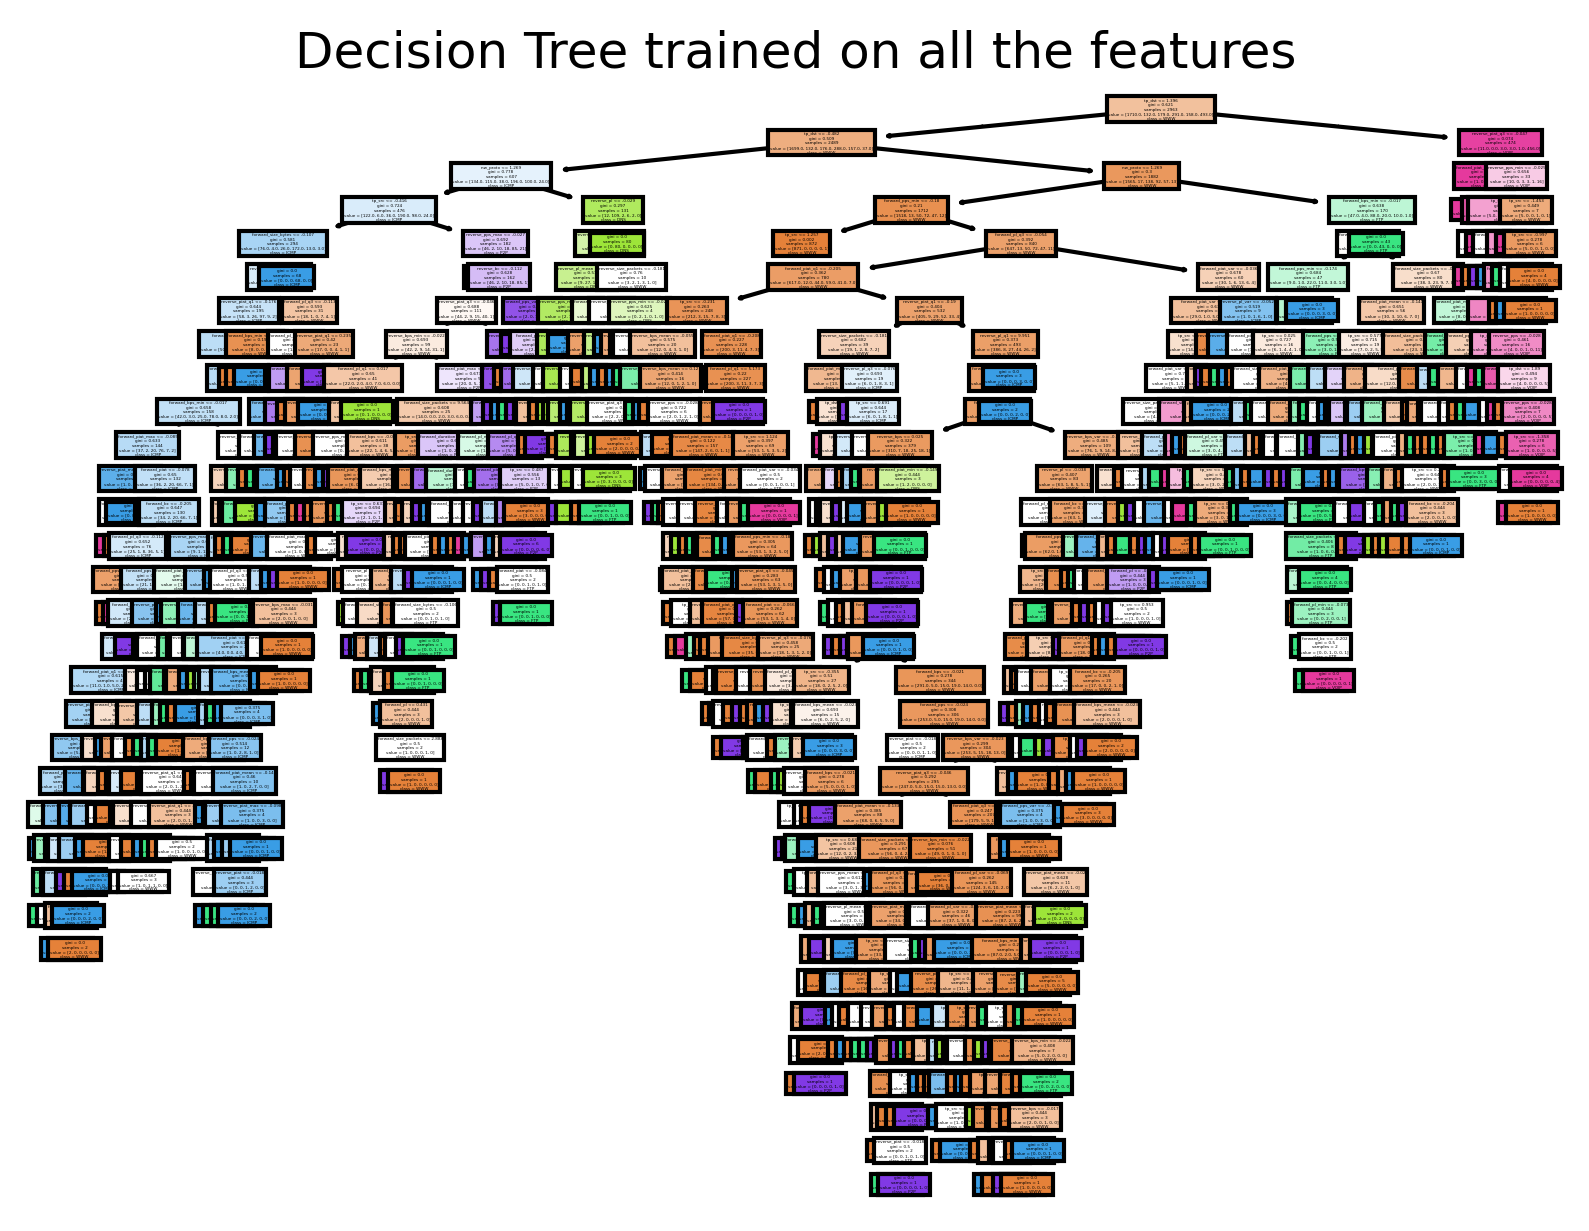

<Axes: title={'center': 'Confusion Matrix'}>

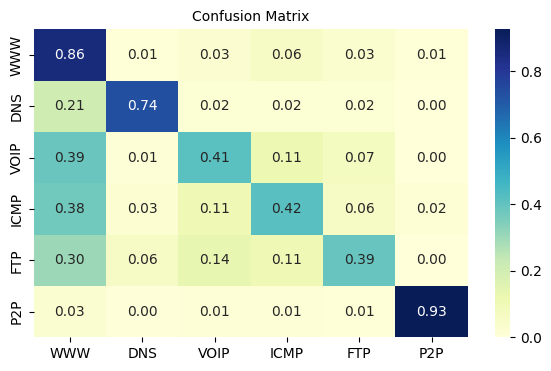

In [7]:
import seaborn as sn
import matplotlib.pyplot as plt

fn = ["forward_bps_var", "tp_src", "tp_dst", "nw_proto", "forward_pc", "forward_bc", "forward_pl", 
    "forward_piat", "forward_pps", "forward_bps", "forward_pl_mean", "forward_piat_mean", 
    "forward_pps_mean", "forward_bps_mean", "forward_pl_var", "forward_piat_var", 
    "forward_pps_var", "forward_pl_q1", "forward_pl_q3", "forward_piat_q1", 
    "forward_piat_q3", "forward_pl_max", "forward_pl_min", "forward_piat_max", 
    "forward_piat_min", "forward_pps_max", "forward_pps_min", "forward_bps_max", 
    "forward_bps_min", "forward_duration", "forward_size_packets", "forward_size_bytes", 
    "reverse_pc", "reverse_bc", "reverse_pl", "reverse_piat", "reverse_pps", "reverse_bps", 
    "reverse_pl_mean", "reverse_piat_mean", "reverse_pps_mean", "reverse_bps_mean", 
    "reverse_pl_var", "reverse_piat_var", "reverse_pps_var", "reverse_bps_var", 
    "reverse_pl_q1", "reverse_pl_q3", "reverse_piat_q1", "reverse_piat_q3", 
    "reverse_pl_max", "reverse_pl_min", "reverse_piat_max", "reverse_piat_min", 
    "reverse_pps_max", "reverse_pps_min", "reverse_bps_max", "reverse_bps_min", 
    "reverse_duration", "reverse_size_packets", "reverse_size_bytes"
]

la = ['WWW', 'DNS', 'FTP', 'ICMP', 'P2P', 'VOIP']
plt.figure(1, dpi=300)
fig = tree.plot_tree(tree_model, feature_names=fn, class_names=la, filled=True)
plt.title("Decision Tree trained on all the features")
plt.show()



labels = unique_categories
plt.figure(2, figsize=(7, 4))
plt.title("Confusion Matrix", fontsize=10)

cmnew = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sn.heatmap(cmnew, annot=True, cmap='YlGnBu', fmt=".2f", xticklabels=labels, yticklabels=labels)

In [8]:
# Initialize classifiers for both algorithms
tree_model_id3 = CustomDecisionTree(max_depth=6, algorithm='ID3')
tree_model_cart = CustomDecisionTree(max_depth=6, algorithm='CART')

# Fit the classifiers
tree_model_id3.fit(X_train, Y_train)
tree_model_cart.fit(X_train, Y_train)

# Predict using both classifiers
predictions_id3 = tree_model_id3.predict(X_test)
predictions_cart = tree_model_cart.predict(X_test)

# Evaluate performance
accuracy_id3 = np.mean(predictions_id3 == Y_test)
accuracy_cart = np.mean(predictions_cart == Y_test)

print(f"ID3 Accuracy: {accuracy_id3}")
print(f"CART Accuracy: {accuracy_cart}")

# Generate classification reports with zero_division handling
report_id3 = classification_report(Y_test, predictions_id3, target_names=unique_categories, zero_division=0)
report_cart = classification_report(Y_test, predictions_cart, target_names=unique_categories, zero_division=0)

print("ID3 Classification Report:")
print(report_id3)

print("CART Classification Report:")
print(report_cart)


ID3 Accuracy: 0.6821400472069237
CART Accuracy: 0.8088119590873328
ID3 Classification Report:
              precision    recall  f1-score   support

         WWW       0.65      0.98      0.79       735
         DNS       1.00      0.64      0.78        53
        VOIP       0.00      0.00      0.00        80
        ICMP       0.00      0.00      0.00       120
         FTP       0.89      0.12      0.21        66
         P2P       0.84      0.47      0.60       217

    accuracy                           0.68      1271
   macro avg       0.56      0.37      0.40      1271
weighted avg       0.61      0.68      0.60      1271

CART Classification Report:
              precision    recall  f1-score   support

         WWW       0.82      0.92      0.87       735
         DNS       0.84      0.81      0.83        53
        VOIP       0.52      0.40      0.45        80
        ICMP       0.57      0.50      0.53       120
         FTP       0.71      0.30      0.43        66
         P